# DSCI 417- Homework 06
**Malcolm Nichols**

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

spark = SparkSession.builder.getOrCreate()

## Problem 1: Load Stroke Data

In [0]:
my_schema =('gender STRING, age DOUBLE, hypertension INTEGER, heart_disease INTEGER, ever_married STRING,'
            'work_type STRING, residence_type STRING, avg_glucose_level DOUBLE, bmi DOUBLE,'
            'smoking_status STRING, stroke INTEGER')

stroke_df = (
    spark.read
    .option('delimiter', ',')
    .option('header', True)
    .schema(my_schema)
    .csv('/FileStore/tables/stroke_data.csv')
)

stroke_df.printSchema()

root
-- gender: string (nullable = true)
-- age: double (nullable = true)
-- hypertension: integer (nullable = true)
-- heart_disease: integer (nullable = true)
-- ever_married: string (nullable = true)
-- work_type: string (nullable = true)
-- residence_type: string (nullable = true)
-- avg_glucose_level: double (nullable = true)
-- bmi: double (nullable = true)
-- smoking_status: string (nullable = true)
-- stroke: integer (nullable = true)

In [0]:
stroke_df.show(10)

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
gender| age|hypertension|heart_disease|ever_married| work_type|residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
Female|13.0| 0| 0| No| Private| Urban| 77.63|31.7| never smoked| 0|
 Male|10.0| 0| 0| No| Child| Rural| 84.02|18.7| never smoked| 0|
Female|82.0| 0| 1| Yes|Self-employed| Rural| 88.6|32.5| Unknown| 0|
Female| 3.0| 0| 0| No| Child| Urban| 57.33|16.8| Unknown| 0|
Female|65.0| 0| 0| Yes|Self-employed| Rural| 220.52|37.2| smokes| 0|
Female|65.0| 0| 0| Yes|Self-employed| Rural| 100.65|31.0| never smoked| 1|
 Male|65.0| 0| 0| Yes| Private| Rural| 56.64|28.4|formerly smoked| 1|
Female|28.0| 0| 0| Yes| Private| Rural| 64.64|22.1| never smoked| 0|
Female|80.0| 0| 0| Yes| Govt_job| Urban| 84.86|29.3| Unknown| 0|
 Male|78.0| 0| 0| Yes| Private| Urban| 60.22|29.7|formerly smoked| 0|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
only showing top 10 rows

In [0]:
N = stroke_df.count()
print(N)

6853

In [0]:
(
    stroke_df
    .groupBy('stroke')
    .agg(expr(f'ROUND(COUNT(*)/{N},4) AS prop'))
    .show()
)

+------+------+
stroke| prop|
+------+------+
 1|0.2907|
 0|0.7093|
+------+------+

## Problem 2: Preprocessing

In [0]:
num_features = ['age', 'avg_glucose_level', 'bmi']
# cat_features = [c for c in stroke_df.columns[:-1] if c not in num_features]
cat_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'residence_type', 'smoking_status']

ix_features = [c + '_ix' for c in cat_features]
vec_features = [c + '_vec' for c in cat_features]

feature_indexer = StringIndexer(inputCols=cat_features, outputCols=ix_features)

encoder = OneHotEncoder(inputCols=ix_features, outputCols=vec_features, dropLast=False)

assembler = VectorAssembler(inputCols=num_features + vec_features, outputCol='features')

In [0]:
pipe_model = Pipeline(stages=[feature_indexer, encoder, assembler]).fit(stroke_df)
train = pipe_model.transform(stroke_df)
train.persist()

train.select('features', 'stroke').show(10, truncate=False)

+----------------------------------------------------------------------------+------+
features |stroke|
+----------------------------------------------------------------------------+------+
(22,[0,1,2,3,5,7,10,11,16,18],[13.0,77.63,31.7,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|0 |
(22,[0,1,2,4,5,7,10,14,17,18],[10.0,84.02,18.7,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|0 |
(22,[0,1,2,3,5,8,9,12,17,19],[82.0,88.6,32.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |0 |
(22,[0,1,2,3,5,7,10,14,16,19],[3.0,57.33,16.8,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |0 |
(22,[0,1,2,3,5,7,9,12,17,21],[65.0,220.52,37.2,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|0 |
(22,[0,1,2,3,5,7,9,12,17,18],[65.0,100.65,31.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|1 |
(22,[0,1,2,4,5,7,9,11,17,20],[65.0,56.64,28.4,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |1 |
(22,[0,1,2,3,5,7,9,11,17,18],[28.0,64.64,22.1,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |0 |
(22,[0,1,2,3,5,7,9,13,16,19],[80.0,84.86,29.3,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |0 |
(22,[0,1,2,4,5,7,9,11,16,20],[78.0,60.22,29.7,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |0 |
+----------------------------------------------------------------------------+------+
only showing top 10 rows

## Problem 3: Hyperparameter Tuning for Logistic Regression

In [0]:
accuracy_eval = MulticlassClassificationEvaluator(
    predictionCol='prediction', labelCol='stroke', metricName='accuracy')

logreg = LogisticRegression(featuresCol='features', labelCol='stroke')

param_grid = (ParamGridBuilder()
              .addGrid(logreg.regParam, [0.0001, 0.001, 0.01, 0.1, 1])
              .addGrid(logreg.elasticNetParam, [0, 0.5, 1])
             ).build()

cv = CrossValidator(estimator=logreg, estimatorParamMaps=param_grid, evaluator=accuracy_eval,
                    numFolds=5, seed=1)
cv_model = cv.fit(train)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
model = cv_model.bestModel

opt_regParam = model.getRegParam()
opt_enetParam = model.getElasticNetParam()

print('Max CV Score:  ', round(max(cv_model.avgMetrics),4))
print('Optimal Lambda:', opt_regParam)
print('Optimal Alpha: ', opt_enetParam)

Max CV Score: 0.7743
Optimal Lambda: 0.01
Optimal Alpha: 0.5

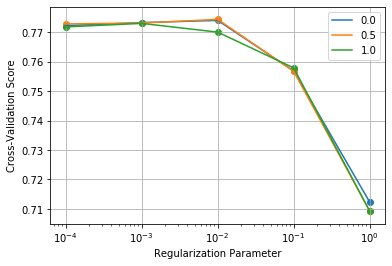

In [0]:
model_params = cv_model.getEstimatorParamMaps()

cv_summary_list = []
for param_set, acc in zip(model_params, cv_model.avgMetrics):
    new_set = list(param_set.values()) + [acc]
    cv_summary_list.append(new_set)
cv_summary = pd.DataFrame(cv_summary_list, columns=['reg_param', 'enet_param', 'acc'])

for en in cv_summary.enet_param.unique():
    sel = cv_summary.enet_param == en
    plt.plot(cv_summary.reg_param[sel], cv_summary.acc[sel], label=en)
    plt.scatter(cv_summary.reg_param[sel], cv_summary.acc[sel])
    
plt.legend()
plt.xscale('log')
plt.grid()
plt.xlabel('Regularization Parameter')
plt.ylabel('Cross-Validation Score')
plt.show()

## Problem 4: Training Predictions

In [0]:
train_pred = model.transform(train)
train_pred.select('probability', 'prediction', 'stroke').show(10, truncate=False)

+-----------------------------------------+----------+------+
probability |prediction|stroke|
+-----------------------------------------+----------+------+
[0.9743346307114529,0.025665369288547124]|0.0 |0 |
[0.9801109026703695,0.019889097329630474]|0.0 |0 |
[0.2672378110872486,0.7327621889127514] |1.0 |0 |
[0.987160738389662,0.012839261610338106] |0.0 |0 |
[0.5277450139992295,0.4722549860007706] |0.0 |0 |
[0.6666106941719837,0.33338930582801635] |0.0 |1 |
[0.6797255507769268,0.32027444922307324] |0.0 |1 |
[0.9481317967168842,0.05186820328311588] |0.0 |0 |
[0.4650651387347953,0.5349348612652047] |1.0 |0 |
[0.4968469411506934,0.5031530588493066] |1.0 |0 |
+-----------------------------------------+----------+------+
only showing top 10 rows

In [0]:
(
    train_pred
    .filter(expr('prediction != stroke'))
    .select('probability', 'prediction', 'stroke')
    .show(10, truncate=False)
)

+----------------------------------------+----------+------+
probability |prediction|stroke|
+----------------------------------------+----------+------+
[0.2672378110872486,0.7327621889127514] |1.0 |0 |
[0.6666106941719837,0.33338930582801635]|0.0 |1 |
[0.6797255507769268,0.32027444922307324]|0.0 |1 |
[0.4650651387347953,0.5349348612652047] |1.0 |0 |
[0.4968469411506934,0.5031530588493066] |1.0 |0 |
[0.28716393118531175,0.7128360688146883]|1.0 |0 |
[0.5091108796927591,0.4908891203072409] |0.0 |1 |
[0.5094917712648722,0.4905082287351278] |0.0 |1 |
[0.5721845123894805,0.4278154876105195] |0.0 |1 |
[0.681740417015643,0.3182595829843569] |0.0 |1 |
+----------------------------------------+----------+------+
only showing top 10 rows

Of the 10 records above:
* The highest probability observed for an incorrect answer is 0.7327 or 73.3%
* The lowest probability observed for an incorrect answer is 0.5031 or 50.3%

## Problem 5: Classification Metrics

In [0]:
pred_and_labels = train_pred.rdd.map(lambda x:(x['prediction'],float(x['stroke'])))

metrics = MulticlassMetrics(pred_and_labels)
print(metrics.accuracy)

0.7752808988764045

In [0]:
cm = metrics.confusionMatrix().toArray().astype(int)
labels = pipe_model.stages[0].labelsArray[1]

pd.DataFrame(
    data=cm,
    columns=labels,
    index=labels
)

Out[14]:

,0,1
0,4302,559
1,981,1011


In [0]:
print('Label   Precision   Recall')
print('--------------------------')
for i, lab in enumerate(labels):
    print(f'{lab:<8}{metrics.precision(i):<12.4f}{metrics.recall(i):.4f}')

Label Precision Recall
--------------------------
0 0.8143 0.8850
1 0.6439 0.5075

## Problem 6: Applying the Model to New Data

In [0]:
new_data = spark.createDataFrame(
    data = [['Female', 42.0, 1, 0, 'No',  'Private',       'Urban', 182.1, 26.8, 'smokes'],
            ['Female', 64.0, 1, 1, 'Yes', 'Self-employed', 'Rural', 171.5, 32.5, 'formerly smoked'],
            ['Male',   37.0, 0, 0, 'Yes', 'Private',       'Rural',  79.2, 18.4, 'Unknown'],
            ['Male',   72.0, 0, 1, 'No',  'Govt_job',      'Urban', 125.7, 19.4, 'never smoked']],
    schema = (
        'gender STRING, age DOUBLE, hypertension INTEGER, heart_disease INTEGER, ever_married STRING,'
        'work_type STRING, residence_type STRING, avg_glucose_level DOUBLE, bmi DOUBLE, smoking_status STRING'
    )
)
new_data.show()

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+
gender| age|hypertension|heart_disease|ever_married| work_type|residence_type|avg_glucose_level| bmi| smoking_status|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+
Female|42.0| 1| 0| No| Private| Urban| 182.1|26.8| smokes|
Female|64.0| 1| 1| Yes|Self-employed| Rural| 171.5|32.5|formerly smoked|
 Male|37.0| 0| 0| Yes| Private| Rural| 79.2|18.4| Unknown|
 Male|72.0| 0| 1| No| Govt_job| Urban| 125.7|19.4| never smoked|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+

In [0]:
pre_pred = pipe_model.transform(new_data)
new_pred = model.transform(pre_pred)
new_pred.select(['probability', 'prediction']).show(truncate=False)

+----------------------------------------+----------+
probability |prediction|
+----------------------------------------+----------+
[0.7357118888518358,0.26428811114816414]|0.0 |
[0.2867644576723629,0.7132355423276371] |1.0 |
[0.9094109695683266,0.09058903043167342]|0.0 |
[0.3748180789350828,0.6251819210649172] |1.0 |
+----------------------------------------+----------+